In [3]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Uncomment it all if you haven't download the TUDelft data yet
#df = dd.read_parquet("hf://datasets/Weijie1996/load_timeseries/30m_resolution_ge/ge_30m.parquet")
#df = df.compute()
# Uncomment below if you wanna save the data frame
#df['datetime'] = pd.to_datetime(df['datetime'])
#df.to_csv('/Users/cisilkaraguzel/Desktop/GitHub/household_energy_consumption_forecasting-1/data/TUDelft.csv', index=False) 

/Users/cisilkaraguzel/Desktop/GitHub/household_energy_consumption_forecasting-1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
df = pd.read_csv("data/TUDelft.csv")
df

,datetime,id,target,category
0,2015-05-21 15:30:00,GE_1,0.157,30m
1,2015-05-21 16:00:00,GE_1,0.584,30m
2,2015-05-21 16:30:00,GE_1,0.545,30m
3,2015-05-21 17:00:00,GE_1,0.677,30m
4,2015-05-21 17:30:00,GE_1,0.351,30m
...,...,...,...,...
232533,2018-04-08 20:00:00,GE_6,0.000,30m
232534,2018-04-08 20:30:00,GE_6,0.000,30m
232535,2018-04-08 21:00:00,GE_6,0.009,30m
232536,2018-04-08 21:30:00,GE_6,0.115,30m


In [31]:
print(df.info())
print(df.head())

print("Columns:", df.columns.tolist())
print("Unique IDs:", df['id'].nunique())
print("Time range:", df['datetime'].min(), "to", df['datetime'].max())


<class 'pandas.core.frame.DataFrame'>
Index: 232538 entries, 31744 to 189470
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  232538 non-null  datetime64[ns]
 1   id        232538 non-null  object        
 2   target    232538 non-null  float64       
 3   category  232538 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 8.9+ MB
None
                 datetime    id  target category
31744 2015-04-15 09:00:00  GE_2   0.000      30m
31745 2015-04-15 09:30:00  GE_2   0.070      30m
31746 2015-04-15 10:00:00  GE_2   0.035      30m
31747 2015-04-15 10:30:00  GE_2   0.045      30m
31748 2015-04-15 11:00:00  GE_2   0.035      30m
Columns: ['datetime', 'id', 'target', 'category']
Unique IDs: 6
Time range: 2015-04-15 09:00:00 to 2019-05-01 22:00:00


In [32]:
print(df.isna().sum())
print(df.describe())

datetime    0
id          0
target      0
category    0
dtype: int64
                            datetime         target
count                         232538  232538.000000
mean   2016-12-03 21:24:05.183152384       0.492859
min              2015-04-15 09:00:00       0.000000
25%              2016-04-04 14:37:30       0.093000
50%              2016-10-23 11:15:00       0.201000
75%              2017-06-22 20:00:00       0.482000
max              2019-05-01 22:00:00     803.940000
std                              NaN       1.856273


In [30]:
print(df.dtypes)
print(df.head())


datetime    datetime64[ns]
id                  object
target             float64
category            object
dtype: object
                 datetime    id  target category
31744 2015-04-15 09:00:00  GE_2   0.000      30m
31745 2015-04-15 09:30:00  GE_2   0.070      30m
31746 2015-04-15 10:00:00  GE_2   0.035      30m
31747 2015-04-15 10:30:00  GE_2   0.045      30m
31748 2015-04-15 11:00:00  GE_2   0.035      30m


In [29]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime') 


/var/folders/3s/cb2cbnx50d36hfcc71dh2wn80000gn/T/ipykernel_13392/176054662.py:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
/Users/cisilkaraguzel/Desktop/GitHub/household_energy_consumption_forecasting-1/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


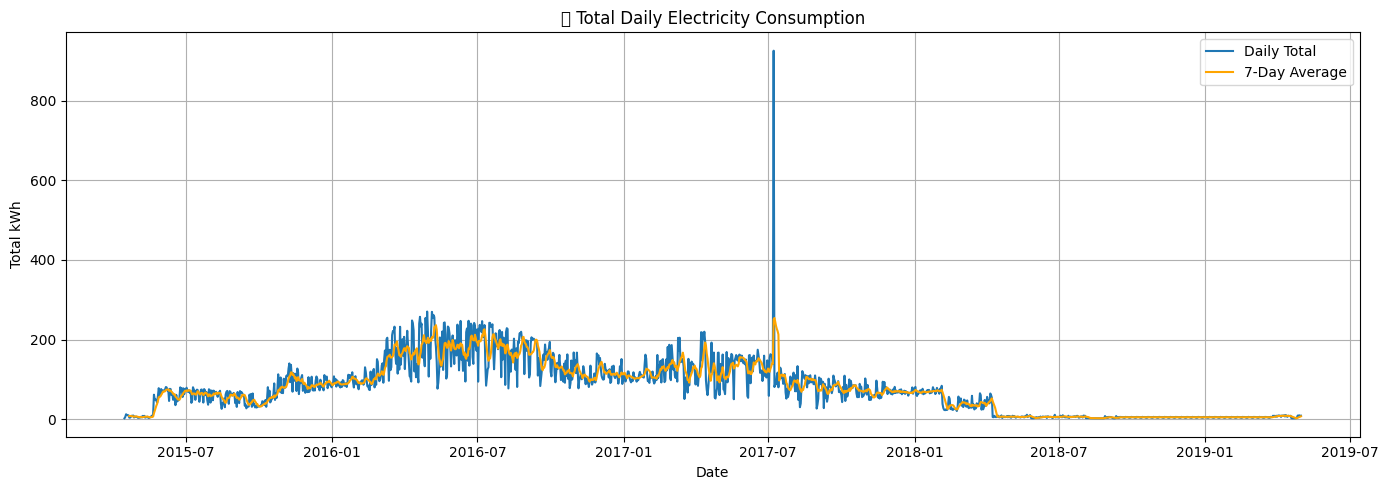

In [19]:
daily_total = df.resample('D', on='datetime')['target'].sum()

plt.figure(figsize=(14, 5))
sns.lineplot(x=daily_total.index, y=daily_total.values, label="Daily Total")
sns.lineplot(x=daily_total.index, y=daily_total.rolling(7).mean(), label="7-Day Average", color='orange')
plt.title("📈 Total Daily Electricity Consumption")
plt.xlabel("Date"); plt.ylabel("Total kWh")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

/var/folders/3s/cb2cbnx50d36hfcc71dh2wn80000gn/T/ipykernel_13392/2507448492.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette="crest")
/var/folders/3s/cb2cbnx50d36hfcc71dh2wn80000gn/T/ipykernel_13392/2507448492.py:7: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.grid(axis='y'); plt.tight_layout(); plt.show()
/Users/cisilkaraguzel/Desktop/GitHub/household_energy_consumption_forecasting-1/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


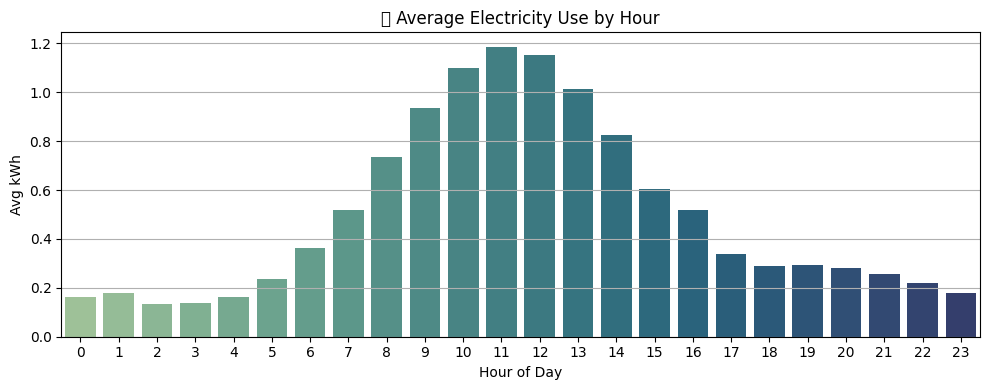

In [20]:
hourly_avg = df.groupby('hour')['target'].mean()

plt.figure(figsize=(10, 4))
sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette="crest")
plt.title("⏱️ Average Electricity Use by Hour")
plt.xlabel("Hour of Day"); plt.ylabel("Avg kWh")
plt.grid(axis='y'); plt.tight_layout(); plt.show()


/var/folders/3s/cb2cbnx50d36hfcc71dh2wn80000gn/T/ipykernel_13392/2399090744.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.legend(title="Household ID"); plt.grid(True); plt.tight_layout(); plt.show()
/Users/cisilkaraguzel/Desktop/GitHub/household_energy_consumption_forecasting-1/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


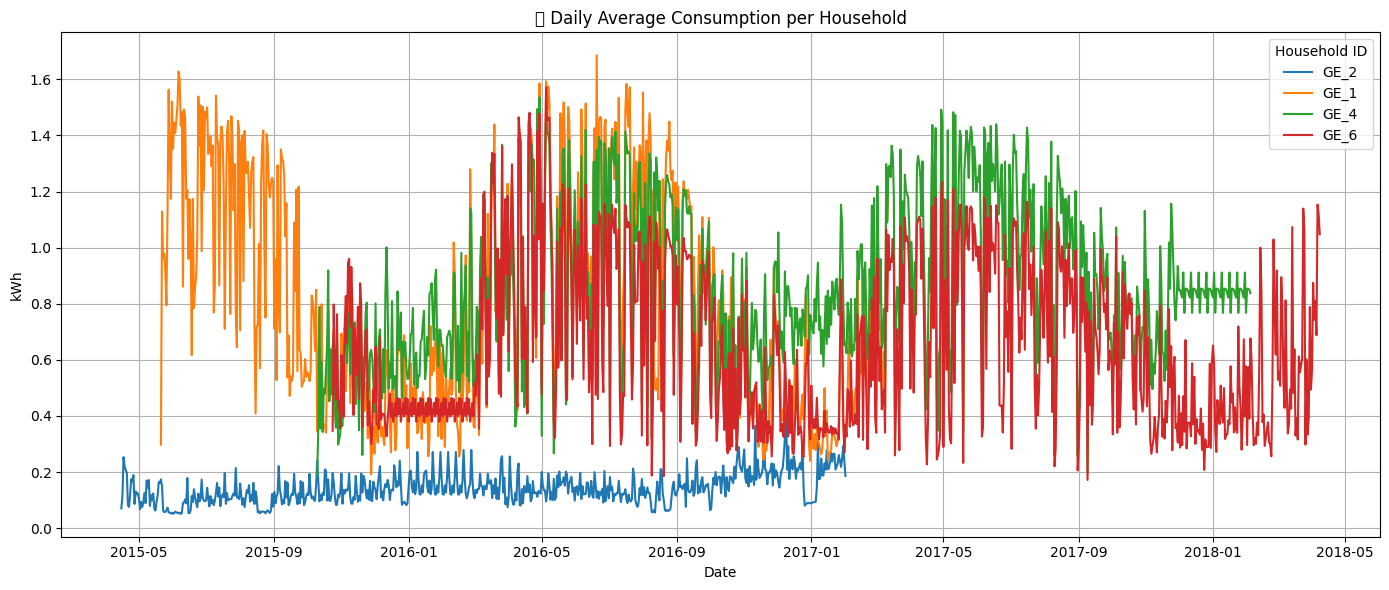

In [21]:
sample_ids = df['id'].unique()[:4]

plt.figure(figsize=(14, 6))
for uid in sample_ids:
    daily_avg = df[df['id'] == uid].set_index('datetime').resample('D')['target'].mean()
    sns.lineplot(x=daily_avg.index, y=daily_avg.values, label=uid)

plt.title("📊 Daily Average Consumption per Household")
plt.xlabel("Date"); plt.ylabel("kWh")
plt.legend(title="Household ID"); plt.grid(True); plt.tight_layout(); plt.show()


/var/folders/3s/cb2cbnx50d36hfcc71dh2wn80000gn/T/ipykernel_13392/428044338.py:11: UserWarning: Glyph 129519 (\N{FIRE EXTINGUISHER}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/Users/cisilkaraguzel/Desktop/GitHub/household_energy_consumption_forecasting-1/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129519 (\N{FIRE EXTINGUISHER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


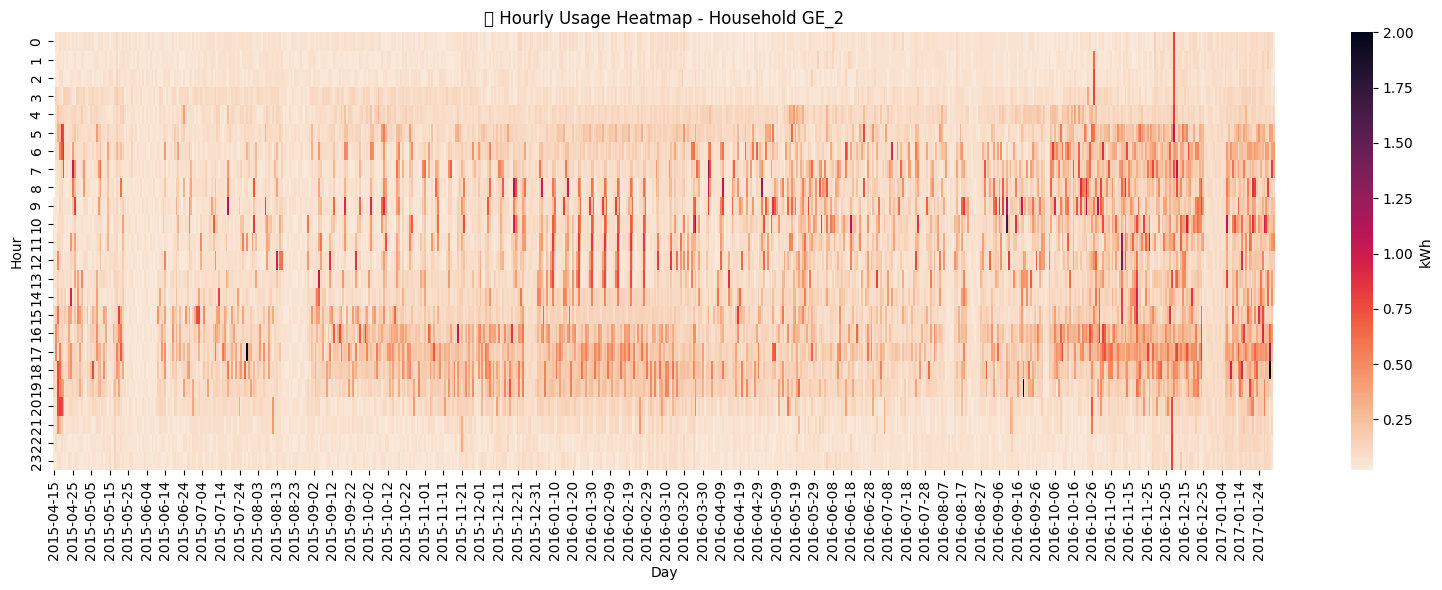

In [22]:
house_id = sample_ids[0]
sub = df[df['id'] == house_id].copy()
sub['day'] = sub['datetime'].dt.date

pivot = sub.pivot_table(index='hour', columns='day', values='target', aggfunc='mean')

plt.figure(figsize=(16, 6))
sns.heatmap(pivot, cmap='rocket_r', cbar_kws={'label': 'kWh'}, vmax=2)
plt.title(f"🧯 Hourly Usage Heatmap - Household {house_id}")
plt.xlabel("Day"); plt.ylabel("Hour")
plt.tight_layout(); plt.show()


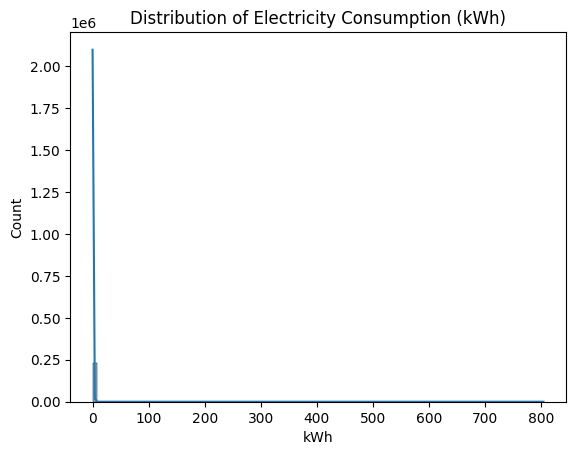

In [14]:
sns.histplot(df['target'], bins=100, kde=True)
plt.title("Distribution of Electricity Consumption (kWh)")
plt.xlabel("kWh")
plt.show()


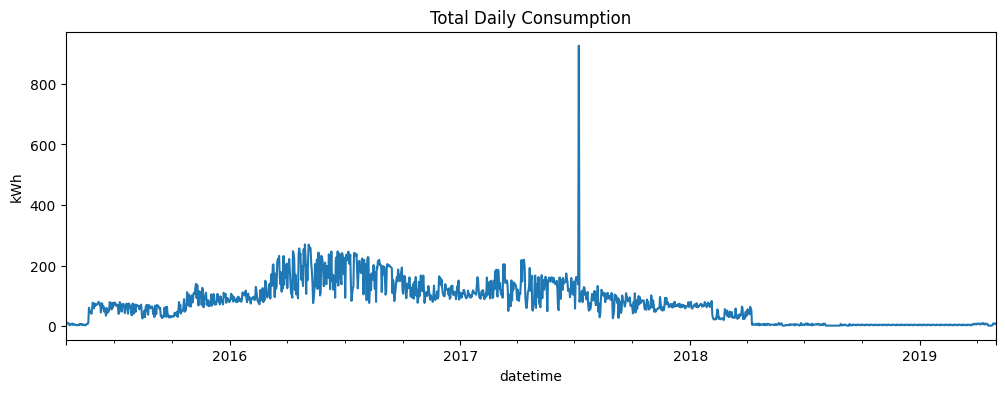

In [28]:
daily_total = df.resample('D', on='datetime')['target'].sum()

daily_total.plot(figsize=(12, 4))
plt.title("Total Daily Consumption")
plt.ylabel("kWh")
plt.show()


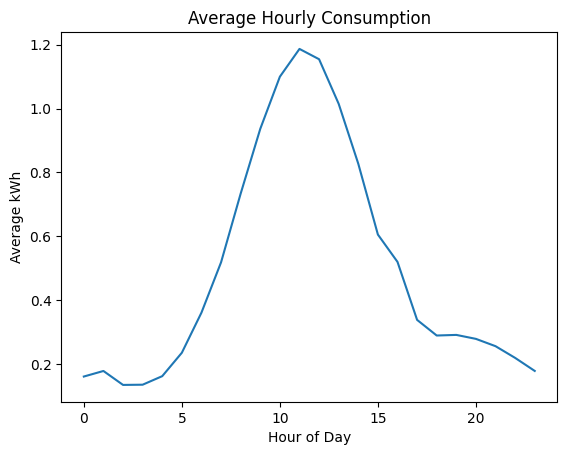

In [29]:
df['hour'] = df['datetime'].dt.hour
hourly_avg = df.groupby('hour')['target'].mean()

sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title("Average Hourly Consumption")
plt.xlabel("Hour of Day")
plt.ylabel("Average kWh")
plt.show()


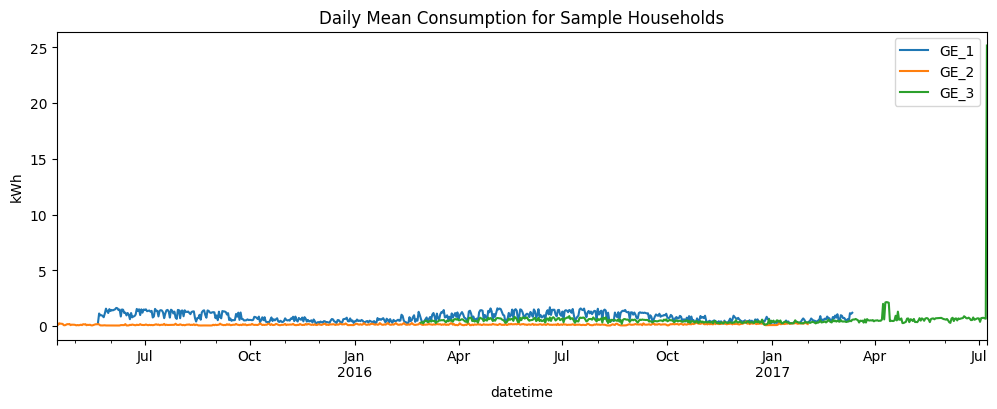

In [30]:
sample_ids = df['id'].unique()[:3]

for uid in sample_ids:
    subset = df[df['id'] == uid].set_index('datetime').resample('D')['target'].mean()
    subset.plot(label=uid, figsize=(12, 4))

plt.title("Daily Mean Consumption for Sample Households")
plt.ylabel("kWh")
plt.legend()
plt.show()


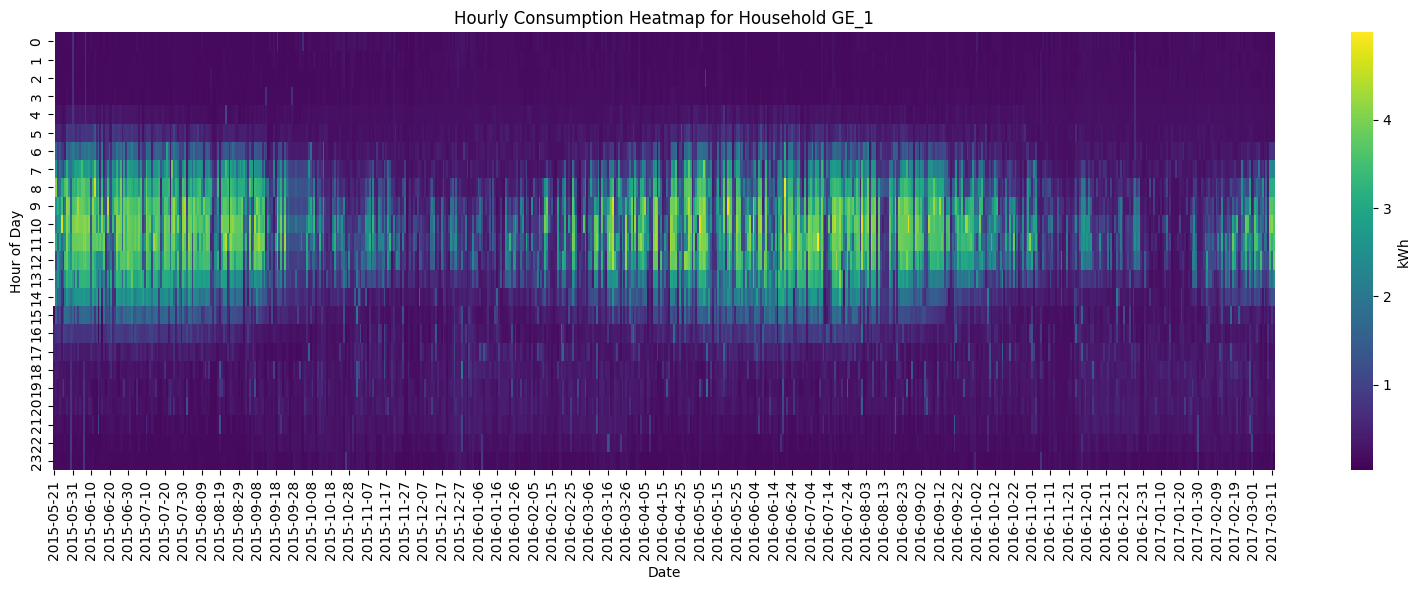

In [31]:
house_id = sample_ids[0]
subset = df[df['id'] == house_id].copy()

subset['day'] = subset['datetime'].dt.date
subset['hour'] = subset['datetime'].dt.hour

pivot_table = subset.groupby(['day', 'hour'])['target'].mean().unstack()

plt.figure(figsize=(16, 6))
sns.heatmap(pivot_table.T, cmap='viridis', cbar_kws={'label': 'kWh'})
plt.title(f"Hourly Consumption Heatmap for Household {house_id}")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()
